In [19]:
# ---------------------------------Load Odrive----------------------------------------------------

In [1]:
'''LOAD ODRIVE'''

from __future__ import print_function
import odrive
from odrive.enums import *
import time, sys
import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from tqdm import tnrange

# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()

# Find an ODrive that is connected on the serial port /dev/ttyUSB0
#my_drive = odrive.find_any("serial:/dev/ttyUSB0")

finding an odrive...


In [ ]:
# -------------------------------------Reboot-------------------------------------------------------

In [40]:
'''REBOOT'''

my_drive.reboot()

ChannelBrokenException: 

In [ ]:
# ---------------------------------Function Definitions----------------------------------------------

In [2]:
'''SET PID FUNCTION'''

def set_PID(pos_gain, vel_gain, vel_integrator_gain):
    # Motor 0
    my_drive.axis0.controller.config.pos_gain = pos_gain
    my_drive.axis0.controller.config.vel_gain = vel_gain
    my_drive.axis0.controller.config.vel_integrator_gain = vel_integrator_gain
    
    # Motor 1
    my_drive.axis1.controller.config.pos_gain = pos_gain
    my_drive.axis1.controller.config.vel_gain = vel_gain
    my_drive.axis1.controller.config.vel_integrator_gain = vel_integrator_gain

In [12]:
'''SET MOTOR 0 ANGLE'''

# 1320 makes axis0 at zero position
# -690 makes axis0 at theta1 90 degrees, counter clockwise
# 3380 makes axis0 at theta1-90 degrees, clockwise
def set_axis0_angle(x):
    if x > 110 or x < -110:
        print("INVALID ANGLE, DEGREES CAN ONLY BE -110 to 110")
    elif x == 0:
        my_drive.axis0.controller.pos_setpoint = 1320 # limit at 102
    elif x > 0:
        setpoint = x/90*-2010+1320  
        my_drive.axis0.controller.pos_setpoint = setpoint
    elif x < 0:   
        setpoint = -x/90*2060+1320  
        my_drive.axis0.controller.pos_setpoint = setpoint
    else:
        setpoint = 1

In [13]:
'''SET MOTOR 1 ANGLE'''

# 1020 makes axis1 at zero position
# -1020 makes axis1 at theta2 at 90, clockwise
# 3055 makes axis 1 at theta2 at -90 degrees, counter clockwise
def set_axis1_angle(x):
    if x > 110 or x < -110:
        print("INVALID ANGLE, DEGREES CAN ONLY BE -110 to 110")
    elif x == 0:
        my_drive.axis1.controller.pos_setpoint = 1020
    elif x > 0:
        setpoint = x/90*-2040+1020  
        my_drive.axis1.controller.pos_setpoint = setpoint
        
    elif x < 0:   
        setpoint = -x/90*2035+1020  
        my_drive.axis1.controller.pos_setpoint = setpoint
        
    else:
        setpoint = 1

In [5]:
'''CHECK IF POS0 AND POS1 IS IN ARRAY'''

def check_in_array(pos0, pos1, array):
    flag = 0
    for i in range(len(array)):
        if array[i] == [pos0, pos1]: # If equal, do a flag
            flag = 1
    
    #return based on flag
    if flag == 1:
        return True
    else:
        return False

In [6]:
'''FIND CLOSEST VALUE OF POS0 AND POS1 ON ARRAY'''

def find_closest(pos0, pos1, array):
    point = [10000, 10000] # Set initial to very large distance first
    
    for i in range(len(array)): # Iterate for length of array
    
        # Calculate closest position
        if ((pos0 - array[i][0])**2 +(pos1 - array[i][1] )**2)**(1/2) < ((pos0 - point[0])**2 +(pos1 - point[1])**2)**(1/2):
            point = [array[i][0],array[i][1]]
            
    return point

In [57]:
# ---------------------------------Configuration Values----------------------------------------------

In [ ]:
'''MOTOR 0 CONFIGURATION'''

my_drive.axis0.controller.config, my_drive.axis0.motor.config, my_drive.axis0.encoder.config

In [3]:
'''MOTOR 1 CONFIGURATION'''

my_drive.axis1.controller.config, my_drive.axis1.motor.config, my_drive.axis1.encoder.config

(control_mode = 3 (int)
 pos_gain = 20.0 (float)
 vel_gain = 0.0005000000237487257 (float)
 vel_integrator_gain = 0.0010000000474974513 (float)
 vel_limit = 20000.0 (float)
 vel_limit_tolerance = 1.2000000476837158 (float)
 vel_ramp_rate = 10000.0 (float)
 setpoints_in_cpr = False (bool), pre_calibrated = True (bool)
 pole_pairs = 7 (int)
 calibration_current = 8.0 (float)
 resistance_calib_max_voltage = 2.0 (float)
 phase_inductance = 0.0 (float)
 phase_resistance = 0.0 (float)
 direction = -1 (int)
 motor_type = 2 (int)
 current_lim = 20.0 (float)
 inverter_temp_limit_lower = 100.0 (float)
 inverter_temp_limit_upper = 120.0 (float)
 requested_current_range = 60.0 (float)
 current_control_bandwidth = 1000.0 (float), mode = 0 (int)
 use_index = True (bool)
 pre_calibrated = True (bool)
 idx_search_speed = 10.0 (float)
 zero_count_on_find_idx = True (bool)
 cpr = 8192 (int)
 offset = -4285 (int)
 offset_float = 0.3259218633174896 (float)
 enable_phase_interpolation = True (bool)
 bandwi

In [3]:
my_drive.vbus_voltage

24.18603515625

In [9]:
'''MOTOR SETUP'''

# Motor 0
my_drive.axis0.motor.config.calibration_current = 8.0
my_drive.axis0.motor.config.current_lim = 20.0
my_drive.axis0.motor.config.motor_type = 2

# Motor 1
my_drive.axis1.motor.config.calibration_current = 8.0
my_drive.axis1.motor.config.current_lim = 10
my_drive.axis1.motor.config.motor_type = 2

In [81]:
# ---------------------------------Calibration modes----------------------------------------------------

In [5]:
'''SET CALIBRATION INDEX SEARCH SPEED'''

my_drive.axis0.encoder.config.idx_search_speed = 3
my_drive.axis1.encoder.config.idx_search_speed = 3

In [13]:
'''SIMULTANEOUS INDEX SEARCH CALIBRATION OF BOTH MOTORS'''

my_drive.axis0.encoder.config.idx_search_speed = 3
my_drive.axis1.encoder.config.idx_search_speed = 3

my_drive.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH
my_drive.axis1.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [116]:
my_drive.axis0.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE

AttributeError: 'RemoteObject' object has no attribute 'axis0'

In [117]:
my_drive.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE

AttributeError: 'RemoteObject' object has no attribute 'axis1'

In [7]:
my_drive.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [8]:
my_drive.axis1.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [101]:
# ---------------------------------Closed Loop Control-------------------------------------------------

In [14]:
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

In [15]:
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

In [16]:
my_drive.axis0.requested_state = AXIS_STATE_IDLE

In [17]:
my_drive.axis1.requested_state = AXIS_STATE_IDLE

In [307]:
'''SET BOTH MOTORS TO HAVE POSITION CONTROL'''

my_drive.axis0.controller.config.control_mode = 3
my_drive.axis1.controller.config.control_mode = 3

In [117]:
# 1320 makes axis0 at zero position, with pos_gain 60
# -690 makes axis0 at theta1 90 degrees, pos_gain 60, counter clockwise
# 3380, -90 degrees, clockwise
my_drive.axis0.controller.pos_setpoint = -40
print("Position setpoint is " + str(my_drive.axis0.controller.pos_setpoint))
print("Angle setpoint is " + str((my_drive.axis0.controller.pos_setpoint+40)/-1900*90))

Position setpoint is -40.0
Angle setpoint is -0.0


In [382]:
# 1020 makes axis1 at zero position, with gain 60
# -1020 makes axis1 at theta2 at 90, with gain 60, clockwise
# 3055, -90 degrees, counter clockwise
my_drive.axis1.controller.pos_setpoint = 7187
print("Position setpoint is " + str(my_drive.axis1.controller.pos_setpoint))
print("Angle setpoint is " + str((my_drive.axis1.controller.pos_setpoint-28165)/-1920*90))

Position setpoint is 7187.0
Angle setpoint is 983.34375


In [19]:
'''DISPLAY MOTOR POSITION'''

while(1):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    sys.stdout.write("\r\rcpr0: " + str(pos0) + " cpr1:" + str(pos1)) 
    time.sleep(0.1)

my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

cpr0: 1140.9854736328125 cpr1:805.750244140625	 vel_setpoint0.0

KeyboardInterrupt: 

In [ ]:
# ---------------------------------Motion Experiments----------------------------------------------------

In [31]:
my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

In [30]:
'''DISPLAY MOTOR POSITION'''

while(1):
    # Record position and print
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    sys.stdout.write("\r\rcpr0: " + str(pos0) + " cpr1:" + str(pos1)) 
    time.sleep(0.1)

cpr0: 1293.234619140625 cpr1:798.9996337890625	 vel_setpoint0.0

KeyboardInterrupt: 

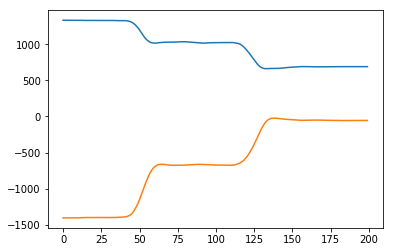

In [32]:
'''RECORD MOTION'''

trajectory_pos = [] # Create array
duration = 2 # Seconds
dt = 0.01 # Seconds
num = int(duration/dt)

# Iterate duration
for _ in range(num):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    trajectory_pos.append([pos0, pos1])
    time.sleep(dt)

# Plot motion
plt.figure(1, figsize=(20,10))
plt.plot(trajectory_pos, '--', label = 'User Position')
plt.legend(loc='upper right')
plt.title('Position Plot', fontsize=18)
plt.xlabel('Time / s', fontsize=16)
plt.ylabel('Encoder position / counts', fontsize=16)

In [31]:
'''STAY IN RECORDED REGION'''

set_PID(100, 4.5e-4, 0)# 650 2e-4 3e-4

my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

# Iterate infinitely
while True:
    
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    
    # Check current position is in array
    if check_in_array(pos0, pos1, trajectory_pos) == False:
        
        # Find closest point in array from current location
        set0, set1 = find_closest(pos0, pos1, trajectory_pos)
        
        # Move position to the region
        my_drive.axis0.controller.pos_setpoint = set0
        my_drive.axis1.controller.pos_setpoint = set1

KeyboardInterrupt: 

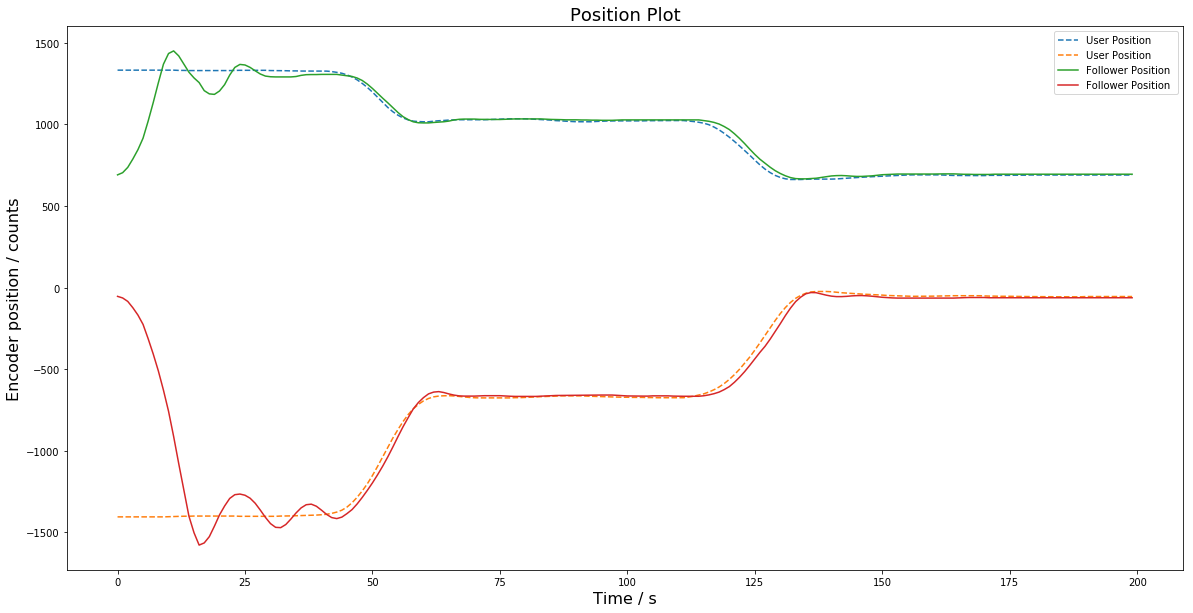

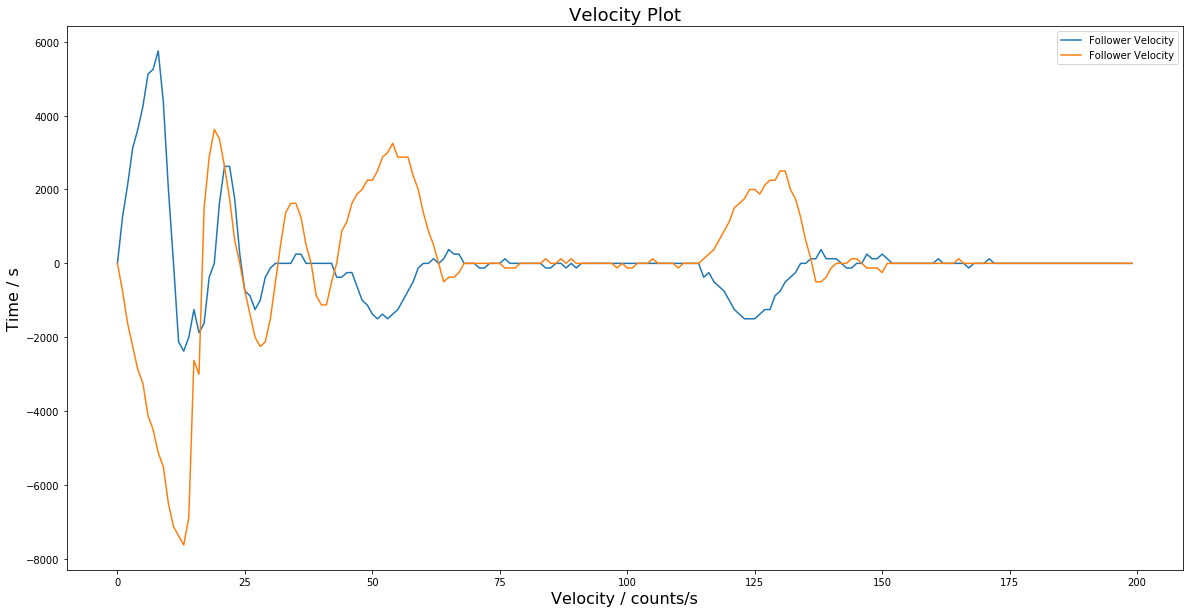

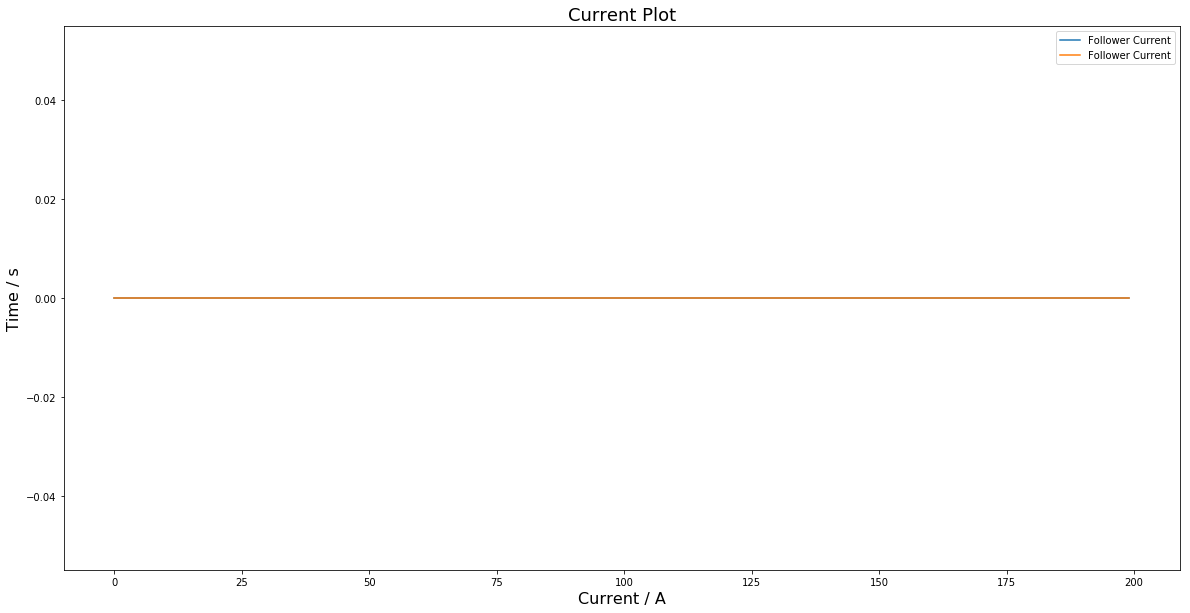

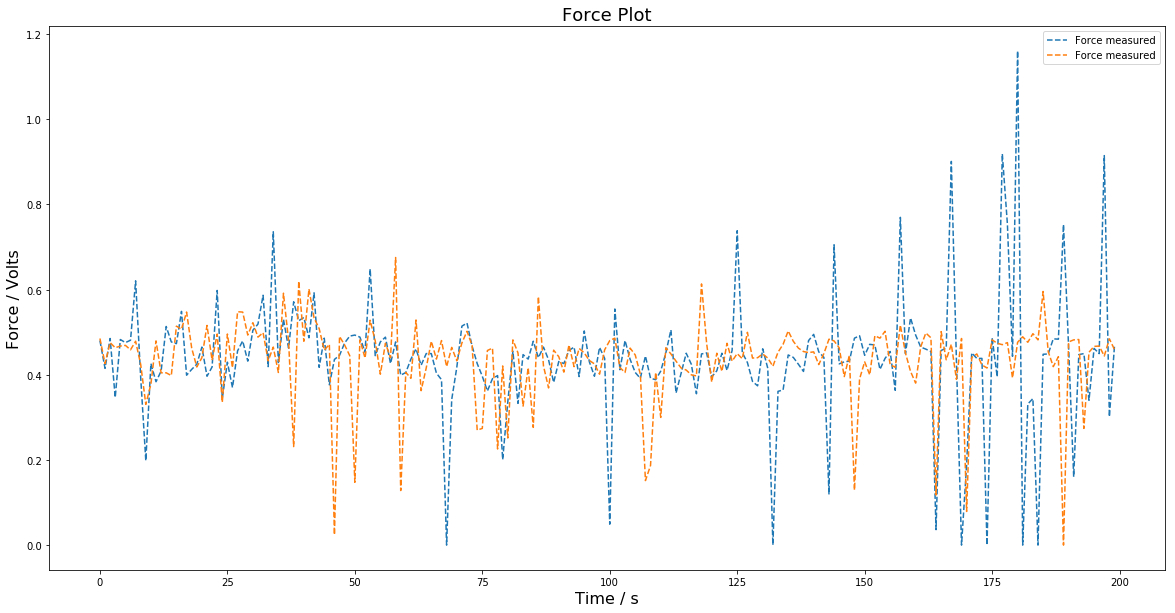

In [34]:
'''FOLLOW THE RECORDED MOTION'''

set_PID(200, 2.5e-4, 2.5e-4)# 650 2e-4 3e-4 or 2.5e-4
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

# Create arrays
trajectory_pos_est = []
trajectory_vel_est = []
trajectory_cur_est = []
force_est = []

# Iterate recorded trajectory positions
for point in trajectory_pos:
    
    set0, set1 = point
    my_drive.axis0.controller.pos_setpoint = set0
    my_drive.axis1.controller.pos_setpoint = set1
    
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    trajectory_pos_est.append([pos0, pos1])
        
    vel0 = my_drive.axis0.encoder.vel_estimate
    vel1 = my_drive.axis1.encoder.vel_estimate
    trajectory_vel_est.append([vel0, vel1])
    
    cur0 = my_drive.axis0.motor.current_control.Iq_measured
    cur1 = my_drive.axis1.motor.current_control.Iq_measured
    trajectory_cur_est.append([cur0, cur1])
    
    force0 = my_drive.get_adc_voltage(4)
    force1 = my_drive.get_adc_voltage(5)
    force_est.append([force0, force1])
    
    time.sleep(dt)
    
    
# Plot the parameters    
plt.figure(1, figsize=(20,10))
plt.plot(trajectory_pos, '--', label = 'User Position')
plt.plot(trajectory_pos_est, '-', label = 'Follower Position ')
plt.legend(loc='upper right')
plt.title('Position Plot', fontsize=18)
plt.xlabel('Time / s', fontsize=16)
plt.ylabel('Encoder position / counts', fontsize=16)

plt.figure(2, figsize=(20,10))
plt.plot(trajectory_vel_est, '-', label = 'Follower Velocity')
plt.legend(loc='upper right')
plt.title('Velocity Plot', fontsize=18)
plt.xlabel('Velocity / counts/s', fontsize=16)
plt.ylabel('Time / s', fontsize=16)

plt.figure(3, figsize=(20,10))
plt.plot(trajectory_cur_est, '-', label = 'Follower Current')
plt.legend(loc='upper right')
plt.title('Current Plot', fontsize=18)
plt.xlabel('Current / A', fontsize=16)
plt.ylabel('Time / s', fontsize=16)

plt.figure(4, figsize=(20,10))
plt.plot(force_est, '--', label = 'Force measured')
plt.legend(loc='upper right')
plt.title('Force Plot', fontsize=18)
plt.xlabel('Time / s', fontsize=16)
plt.ylabel('Force / Volts', fontsize=16)

# Stop closed-loop control
my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

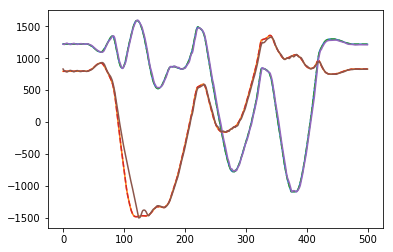

In [23]:
'''RECORD AND FOLLOW'''

trajectory = []
duration = 5 # seconds
dt = 0.01 # seconds
num = int(duration/dt)

for _ in range(num):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate

    trajectory.append([pos0, pos1])
    time.sleep(dt)
    
plt.plot(trajectory)

time.sleep(2)

set_PID(600, 3e-4, 2.5e-4)

trajectory_est = []
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

for point in trajectory:
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    trajectory_est.append([pos0, pos1])
    
    set0, set1 = point
    my_drive.axis0.controller.pos_setpoint = set0
    my_drive.axis1.controller.pos_setpoint = set1
    
    time.sleep(dt)
    
#for point in reversed(trajectory):
#    pos0 = my_drive.axis0.encoder.pos_estimate
#    pos1 = my_drive.axis1.encoder.pos_estimate
#    trajectory_est.append([pos0, pos1])
   
#    set0, set1 = point
#    my_drive.axis0.controller.pos_setpoint = set0
#    my_drive.axis1.controller.pos_setpoint = set1
    
#    time.sleep(dt)
    
plt.plot(trajectory, '--')
plt.plot(trajectory_est)

my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

In [ ]:
'''SIMPLE MOTIONS'''

duration = 10 # seconds
dt = 0.01 # seconds
num = int(duration/dt)

my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

set_PID(8, 0.0006, 0.0)

# A sine wave to test
t0 = time.monotonic()
time.sleep(1.7)
t1 = time.monotonic()

for _ in range(num):
    
    setpoint = 1000.0 * math.sin((time.monotonic() - t0)*3)
    setpoint1 = 1000.0 * math.sin((time.monotonic() - t1)*3)
    # print("goto " + str(int(setpoint)))

    # go up and down trajectory
    my_drive.axis0.controller.pos_setpoint = setpoint-1000
    my_drive.axis1.controller.pos_setpoint = (setpoint-1000)

    # make circle
    #my_drive.axis0.controller.pos_setpoint = setpoint-1500
    #my_drive.axis1.controller.pos_setpoint = (setpoint1-1500)
    
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate

    trajectory.append([pos0, pos1])
    time.sleep(dt)
    
plt.plot(trajectory)

my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

In [ ]:
# -------------------------------Force Sensor Experiments-----------------------------------------------

In [101]:
my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLE

In [ ]:
'''PRINT ENCODER ANGLE'''

while(1):
    pos0 = my_drive.axis0.encoder.pos_estimate
    pos1 = my_drive.axis1.encoder.pos_estimate
    angle0 = (pos0 - 1320) / -2010 * 90
    angle1 = (pos1 - 1020) / -2040 * 90
    sys.stdout.write("\r\rangle0: " + str(angle0) + " angle1:" + str(angle1)) # Print
    time.sleep(0.1)

In [115]:
'''FORCE MAPPING'''

set_PID(200, 2.5e-4, 2.5e-4)
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

# Create array
force_mapping = []

# Iterate Motor1 angle from 105 to -105 degrees
for i in range(105, -105, -1):
    
    set_axis1_angle(i)

    # Iterate Motor0 angle
    for j in range(-(i-15), -(i-160), 1):
        if j > 105:
            break
        set_axis0_angle(j)
        if j == -(i-15):
            time.sleep(3)    
        time.sleep(.7)
        
        # Record and save position and force
        pos0 = my_drive.axis0.encoder.pos_estimate
        pos1 = my_drive.axis1.encoder.pos_estimate
        force0 = my_drive.get_adc_voltage(4)
        force1 = my_drive.get_adc_voltage(5)
        force_mapping.append([pos0, pos1, force0, force1])

# Redefine array        
force_mapping = np.array(force_mapping)     

# Plot motor position and force measured
plt.figure(1, figsize=(20,10))
plt.plot(force_mapping[:, [0, 1]], '--', label = 'Motor Position')
plt.legend(loc='upper right')
plt.title('Position Plot', fontsize=18)
plt.xlabel('Time / s', fontsize=16)
plt.ylabel('Encoder position / counts', fontsize=16)

plt.figure(2, figsize=(20,10))
plt.plot(force_mapping[:, [2, 3]], '--', label = 'Force Measured')
plt.legend(loc='upper right')
plt.title('Force Plot', fontsize=18)
plt.xlabel('Time / s', fontsize=16)
plt.ylabel('Force / Voltage', fontsize=16)

# Display array
force_mapping
force_mapping[:, [2, 3]]

KeyboardInterrupt: 

In [ ]:
# ---------------------------------Index Saving Setup---------------------------------------------------

In [ ]:
# With this configuration, we only need to do this after each reboot:
# my_drive.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [19]:
my_drive.axis0.encoder.config.use_index = True

In [20]:
my_drive.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [21]:
my_drive.axis0.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE

In [22]:
my_drive.axis0.encoder.config.pre_calibrated = True

In [23]:
my_drive.axis0.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [24]:
my_drive.axis0.motor.config.pre_calibrated = True

In [25]:
my_drive.save_configuration()

In [29]:
my_drive.axis1.encoder.config.use_index = True

In [31]:
my_drive.axis1.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [32]:
my_drive.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE

In [33]:
my_drive.axis1.encoder.config.pre_calibrated = True

In [34]:
my_drive.axis1.requested_state = AXIS_STATE_ENCODER_INDEX_SEARCH

In [35]:
my_drive.axis1.motor.config.pre_calibrated = True

In [7]:
my_drive.save_configuration()

In [71]:
# ---------------------------------Testings-----------------------------------------------------------

In [184]:
my_drive.axis1.encoder.pos_estimate

2.999999761581421

In [185]:
my_drive.axis1.encoder.vel_estimate

0.0

In [68]:
my_drive.axis0.motor.current_control.Iq_measured

0.0

In [ ]:
# ---------------------------------Configurations------------------------------------------------------

In [18]:
'''MOTOR AND ENCODER CONFIGURATIONS'''

my_drive.axis0.requested_state = AXIS_STATE_IDLE
my_drive.axis1.requested_state = AXIS_STATE_IDLEmy_drive.axis0.motor.config.pre_calibrated = False 
my_drive.axis0.motor.config.pole_pairs = 7 
my_drive.axis0.motor.config.calibration_current = 8.0 
my_drive.axis0.motor.config.resistance_calib_max_voltage = 2.0 
my_drive.axis0.motor.config.phase_inductance = 0.0
my_drive.axis0.motor.config.phase_resistance = 0.0 
my_drive.axis0.motor.config.direction = -1 
my_drive.axis0.motor.config.motor_type = 2 
my_drive.axis0.motor.config.current_lim = 20.0 
my_drive.axis0.motor.config.requested_current_range = 60.0 
my_drive.axis0.encoder.config.mode = 0 
my_drive.axis0.encoder.config.use_index = False
my_drive.axis0.encoder.config.pre_calibrated = False
my_drive.axis0.encoder.config.idx_search_speed = 10.0 
my_drive.axis0.encoder.config.cpr = 8192
my_drive.axis0.encoder.config.offset = -4392 
my_drive.axis0.encoder.config.offset_float = -0.030671894550323486 
my_drive.axis0.encoder.config.calib_range = 0.019999999552965164

my_drive.axis1.motor.config.pre_calibrated = False 
my_drive.axis1.motor.config.pole_pairs = 7 
my_drive.axis1.motor.config.calibration_current = 8.0 
my_drive.axis1.motor.config.resistance_calib_max_voltage = 2.0 
my_drive.axis1.motor.config.phase_inductance = 0.0
my_drive.axis1.motor.config.phase_resistance = 0.0 
my_drive.axis1.motor.config.direction = -1 
my_drive.axis1.motor.config.motor_type = 2 
my_drive.axis1.motor.config.current_lim = 20.0 
my_drive.axis1.motor.config.requested_current_range = 60.0 
my_drive.axis1.encoder.config.mode = 0 
my_drive.axis1.encoder.config.use_index = False
my_drive.axis1.encoder.config.pre_calibrated = False
my_drive.axis1.encoder.config.idx_search_speed = 10.0 
my_drive.axis1.encoder.config.cpr = 8192
my_drive.axis1.encoder.config.offset = -4392 
my_drive.axis1.encoder.config.offset_float = -0.030671894550323486 
my_drive.axis1.encoder.config.calib_range = 0.019999999552965164

In [ ]:
'''PID CONFIGURATIONS'''   
    # Default control
    my_drive.axis0.controller.config.vel_integrator_gain = 0.0010000000474974513
    my_drive.axis0.controller.config.vel_gain = 0.0005000000237487257
    my_drive.axis0.controller.config.pos_gain = 20.0

    # Spring-like control
    my_drive.axis0.controller.config.vel_integrator_gain = 0
    my_drive.axis0.controller.config.vel_gain = 0.0003
    my_drive.axis0.controller.config.pos_gain = 5

    # Testing out control
    my_drive.axis0.controller.config.vel_integrator_gain = 0
    my_drive.axis0.controller.config.vel_gain = 0.00035
    my_drive.axis0.controller.config.pos_gain = 6

In [ ]:
# ----------------------------------Other features-----------------------------------------------------

In [223]:
# To read a value, simply read the property
print("Bus voltage is " + str(my_drive.vbus_voltage) + "V")

# Or to change a value, just assign to the property
my_drive.axis0.controller.pos_setpoint = 3.14
print("Position setpoint is " + str(my_drive.axis0.controller.pos_setpoint))

Bus voltage is 24.201343536376953V
Position setpoint is 3.140000104904175


In [68]:
# And this is how function calls are done:
for i in [1,2,3,4,5,6,7,8]:
    print('voltage on GPIO{} is {} Volt'.format(i, my_drive.get_adc_voltage(i)))

voltage on GPIO1 is 0.8080810308456421 Volt
voltage on GPIO2 is 0.6751464605331421 Volt
voltage on GPIO3 is 0.724291980266571 Volt
voltage on GPIO4 is 0.7750487923622131 Volt
voltage on GPIO5 is 1.9384276866912842 Volt
voltage on GPIO6 is 0.8113036751747131 Volt
voltage on GPIO7 is 0.814526379108429 Volt
voltage on GPIO8 is 0.8193603157997131 Volt


In [39]:
while(1):
    force0 = my_drive.get_adc_voltage(4)
    force1 = my_drive.get_adc_voltage(5)
    sys.stdout.write("\r\rforce0: " + str(force0) + " force1:" + str(force1)) 
    time.sleep(0.1)

force0: 1.7998534440994263 force1:1.5992431640625

KeyboardInterrupt: 

In [67]:
my_drive.GPIO_set_to_analog(my_drive.get_gpio_port_by_pin(1), 1);

AttributeError: 'RemoteObject' object has no attribute 'GPIO_set_to_analog'

In [49]:
my_drive.get_adc_voltage(1)

0.813720703125

In [43]:
my_drive.get_gpio_port_by_pin(1)

AttributeError: 'RemoteObject' object has no attribute 'get_gpio_port_by_pin'

In [206]:
# A sine wave to test
t0 = time.monotonic()
time.sleep(1.7)
t1 = time.monotonic()

while True:
    # prev 10000.0
    setpoint = 1000.0 * math.sin((time.monotonic() - t0)*3)
    setpoint1 = 1000.0 * math.sin((time.monotonic() - t1)*3)
#     print("goto " + str(int(setpoint)))

    # go up and down trajectory
    #my_drive.axis0.controller.pos_setpoint = setpoint-1000
    #my_drive.axis1.controller.pos_setpoint = (setpoint-1000)

    # make circle
    my_drive.axis0.controller.pos_setpoint = setpoint-1500
    my_drive.axis1.controller.pos_setpoint = (setpoint1-1500)
    
    
    time.sleep(0.001)

# Some more things you can try:

KeyboardInterrupt: 

In [152]:
# Write to a read-only property:
my_drive.vbus_voltage = 11.0  # fails with `AttributeError: can't set attribute`

# Assign an incompatible value:
my_drive.motor0.pos_setpoint = "I like trains"  # fails with `ValueError: could not convert string to float`

AttributeError: Attribute vbus_voltage not found

In [ ]:
import sys
sys.version